#Ventilator

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [ ]:
path = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

# 간단 EDA

- id: globally-unique time step identifier across an entire file **전체 번호**
- breath_id: globally-unique time step for breaths **각 환자 번호**
- R: lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow. **기도가 얼마나 막혔는지(음료를 빨대로 마실 때 빨대를 조였다 폈다하는 것과 같다) 흐름 변화당 압력 변화 ~ 높은 R일수록 불기 어렵다**
- C: lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow. **폐의 순응력(같은 부피라도 풍선에 재질에 따라 쉽게 불러지는 것이 있고 어려운 것이 있다) 압력 변화당 부피 변화 ~ 높은 C 일수록 쉽게 불러진다**
- time_step: the actual time stamp. **각 환자의 타임스텝**
- u_in: the control input for the inspiratory solenoid valve. Ranges from 0 to 100. **inspiratory solenoid valve 흡기 벨브(?) [0.100]**
- u_out: the control input for the exploratory solenoid valve. Either 0 or 1. **exploratory solenoid valve 예비 벨브(?) 0 or 1**
- pressure: the airway pressure measured in the respiratory circuit, measured in cmH2O. **공기압(Target)**

In [ ]:
print(train.shape)
train.tail()

(6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938
6035999,6036000,125749,50,10,2.638017,1.482739,1,3.869032


In [ ]:
print(test.shape)
test.head()

(4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [ ]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [ ]:
train['R'].unique()

array([20, 50,  5])

In [ ]:
train['C'].unique()

array([50, 20, 10])

breath_id 당 개수 확인

A: 모두 80개씩

In [ ]:
print('breath_id 개수 :', len(train['breath_id'].unique()))
print('breath_id 당 개수 :', train['breath_id'].value_counts().unique())

breath_id 개수 : 75450
breath_id 당 개수 : [80]


In [ ]:
train[train['breath_id'] == 8] ## 일부는 test에 있다.

,id,breath_id,R,C,time_step,u_in,u_out,pressure


#Data Preprocessing

##Train

u_in을 범위로 나누기

0, 4, 8, 12, ..., 100으로 4씩 증가


In [ ]:
t = 4
for i in range(0, 100+1, t):
    if i != 0:
        train['u_in_' + str(i)] = (train['u_in'] <= i).astype(int)
        train['u_in_' + str(i)] += train['u_in_' + str(i-t)]
    else:
        train.loc[:, 'u_in_' + str(i)] = (train['u_in'] <= i).astype(int)

for i in range(0, 100+1, t):
    train['u_in_' + str(i)] = train['u_in_' + str(i)] == 1

train = train.drop(['u_in'], axis=1)

R과 C를 원핫 인코딩

In [ ]:
train = pd.get_dummies(train, columns=['R', 'C'], prefix=['R', 'C'], prefix_sep='')
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
for r in R_col:
    for c in C_col:
        train.loc[:, r+'_'+c] = train[r]*train[c]

train = train.drop(R_col+C_col, axis=1)

del R_col
del C_col

timestep는 시각이므로 시간(전후 시각 차이)로 바꾸자

In [ ]:
train_tmp = train.drop(['id', 'breath_id'], axis=1)
train_tmp.loc[:, 'time'] = train_tmp['time_step'].diff()
# time을 standardization하자
mu = train_tmp['time'].mean()
std = train_tmp['time'].std()
train_tmp['time'] = (train_tmp['time'] - mu) / std
train_tmp = train_tmp.drop(['time_step'], axis=1)

sample_size = 80

In [ ]:
train_R5C10 = train_tmp[train_tmp['R5_C10'] == 1]
target_R5C10 = train_R5C10['pressure']
train_R5C10 = train_R5C10.drop(['pressure'], axis=1)
for i in range(train_R5C10.shape[0] // 80):
  train_R5C10.iloc[80*i, -1] = 0

train_R5C20 = train_tmp[train_tmp['R5_C20'] == 1]
target_R5C20 = train_R5C20['pressure']
train_R5C20 = train_R5C20.drop(['pressure'], axis=1)
for i in range(train_R5C20.shape[0] // 80):
  train_R5C20.iloc[80*i, -1] = 0

train_R5C50 = train_tmp[train_tmp['R5_C50'] == 1]
target_R5C50 = train_R5C50['pressure']
train_R5C50 = train_R5C50.drop(['pressure'], axis=1)
for i in range(train_R5C50.shape[0] // 80):
  train_R5C50.iloc[80*i, -1] = 0

train_R20C10 = train_tmp[train_tmp['R5_C10'] == 1]
target_R20C10 = train_R20C10['pressure']
train_R20C10 = train_R20C10.drop(['pressure'], axis=1)
for i in range(train_R20C10.shape[0] // 80):
  train_R20C10.iloc[80*i, -1] = 0

train_R20C20 = train_tmp[train_tmp['R20_C20'] == 1]
target_R20C20 = train_R20C20['pressure']
train_R20C20 = train_R20C20.drop(['pressure'], axis=1)
for i in range(train_R20C20.shape[0] // 80):
  train_R20C20.iloc[80*i, -1] = 0

train_R20C50 = train_tmp[train_tmp['R20_C50'] == 1]
target_R20C50 = train_R20C50['pressure']
train_R20C50 = train_R20C50.drop(['pressure'], axis=1)
for i in range(train_R20C50.shape[0] // 80):
  train_R20C50.iloc[80*i, -1] = 0

train_R50C10 = train_tmp[train_tmp['R50_C10'] == 1]
target_R50C10 = train_R50C10['pressure']
train_R50C10 = train_R50C10.drop(['pressure'], axis=1)
for i in range(train_R50C10.shape[0] // 80):
  train_R50C10.iloc[80*i, -1] = 0

train_R50C20 = train_tmp[train_tmp['R50_C20'] == 1]
target_R50C20 = train_R50C20['pressure']
train_R50C20 = train_R50C20.drop(['pressure'], axis=1)
for i in range(train_R50C20.shape[0] // 80):
  train_R50C20.iloc[80*i, -1] = 0

train_R50C50 = train_tmp[train_tmp['R50_C50'] == 1]
target_R50C50 = train_R50C50['pressure']
train_R50C50 = train_R50C50.drop(['pressure'], axis=1)
for i in range(train_R50C50.shape[0] // 80):
  train_R50C50.iloc[80*i, -1] = 0

feature_num = train_R50C50.shape[1]

del train
del train_tmp

## Test

In [ ]:
t = 4
for i in range(0, 100+1, t):
    if i != 0:
        test['u_in_' + str(i)] = (test['u_in'] <= i).astype(int)
        test['u_in_' + str(i)] += test['u_in_' + str(i-t)]
    else:
        test.loc[:, 'u_in_' + str(i)] = (test['u_in'] <= i).astype(int)

for i in range(0, 100+1, t):
    test['u_in_' + str(i)] = test['u_in_' + str(i)] == 1

test = test.drop(['u_in'], axis=1)

In [ ]:
test = pd.get_dummies(test, columns=['R', 'C'], prefix=['R', 'C'], prefix_sep='')
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
for r in R_col:
    for c in C_col:
        test.loc[:, r+'_'+c] = test[r]*test[c]

test = test.drop(R_col+C_col, axis=1)

del R_col
del C_col

In [ ]:
test_tmp = test.drop(['breath_id'], axis=1) # 'id', 
test_tmp.loc[:, 'time'] = test_tmp['time_step'].diff()
test_tmp = test_tmp.drop(['time_step'], axis=1)
# train set에서 구한 mu와 std로 standardization
test_tmp['time'] = (test_tmp['time'] - mu) / std

In [ ]:
test_R5C10 = test_tmp[test_tmp['R5_C10'] == 1]
for i in range(test_R5C10.shape[0] // 80):
  test_R5C10.iloc[80*i, -1] = 0

test_R5C20 = test_tmp[test_tmp['R5_C20'] == 1]
for i in range(test_R5C20.shape[0] // 80):
  test_R5C20.iloc[80*i, -1] = 0

test_R5C50 = test_tmp[test_tmp['R5_C50'] == 1]
for i in range(test_R5C50.shape[0] // 80):
  test_R5C50.iloc[80*i, -1] = 0

test_R20C10 = test_tmp[test_tmp['R5_C10'] == 1]
for i in range(test_R20C10.shape[0] // 80):
  test_R20C10.iloc[80*i, -1] = 0

test_R20C20 = test_tmp[test_tmp['R20_C20'] == 1]
for i in range(test_R20C20.shape[0] // 80):
  test_R20C20.iloc[80*i, -1] = 0

test_R20C50 = test_tmp[test_tmp['R20_C50'] == 1]
for i in range(test_R20C50.shape[0] // 80):
  test_R20C50.iloc[80*i, -1] = 0

test_R50C10 = test_tmp[test_tmp['R50_C10'] == 1]
for i in range(test_R50C10.shape[0] // 80):
  test_R50C10.iloc[80*i, -1] = 0

test_R50C20 = test_tmp[test_tmp['R50_C20'] == 1]
for i in range(test_R50C20.shape[0] // 80):
  test_R50C20.iloc[80*i, -1] = 0

test_R50C50 = test_tmp[test_tmp['R50_C50'] == 1]
for i in range(test_R50C50.shape[0] // 80):
  test_R50C50.iloc[80*i, -1] = 0


del test
del test_tmp

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d


## dataframe을 numpy로

### Train

In [ ]:
X_train_R5C10 = np.zeros((train_R5C10.shape[0]//sample_size, sample_size, feature_num))
y_train_R5C10 = np.zeros((train_R5C10.shape[0]//sample_size, sample_size))
for i in range(X_train_R5C10.shape[0]):
    X_train_R5C10[i, :, :] = train_R5C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R5C10[i, :] = np.array(target_R5C10.iloc[sample_size*i : sample_size*(i+1)])

X_train_R5C20 = np.zeros((train_R5C20.shape[0]//sample_size, sample_size, feature_num))
y_train_R5C20 = np.zeros((train_R5C20.shape[0]//sample_size, sample_size))
for i in range(X_train_R5C20.shape[0]):
    X_train_R5C20[i, :, :] = train_R5C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R5C20[i, :] = np.array(target_R5C20.iloc[sample_size*i : sample_size*(i+1)])

X_train_R5C50 = np.zeros((train_R5C50.shape[0]//sample_size, sample_size, feature_num))
y_train_R5C50 = np.zeros((train_R5C50.shape[0]//sample_size, sample_size))
for i in range(X_train_R5C50.shape[0]):
    X_train_R5C50[i, :, :] = train_R5C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R5C50[i, :] = np.array(target_R5C50.iloc[sample_size*i : sample_size*(i+1)])

X_train_R20C10 = np.zeros((train_R20C10.shape[0]//sample_size, sample_size, feature_num))
y_train_R20C10 = np.zeros((train_R20C10.shape[0]//sample_size, sample_size))
for i in range(X_train_R20C10.shape[0]):
    X_train_R20C10[i, :, :] = train_R20C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R20C10[i, :] = np.array(target_R20C10.iloc[sample_size*i : sample_size*(i+1)])

X_train_R20C20 = np.zeros((train_R20C20.shape[0]//sample_size, sample_size, feature_num))
y_train_R20C20 = np.zeros((train_R20C20.shape[0]//sample_size, sample_size))
for i in range(X_train_R20C20.shape[0]):
    X_train_R20C20[i, :, :] = train_R20C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R20C20[i, :] = np.array(target_R20C20.iloc[sample_size*i : sample_size*(i+1)])

X_train_R20C50 = np.zeros((train_R20C50.shape[0]//sample_size, sample_size, feature_num))
y_train_R20C50 = np.zeros((train_R20C50.shape[0]//sample_size, sample_size))
for i in range(X_train_R20C50.shape[0]):
    X_train_R20C50[i, :, :] = train_R20C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R20C50[i, :] = np.array(target_R20C50.iloc[sample_size*i : sample_size*(i+1)])

X_train_R50C10 = np.zeros((train_R50C10.shape[0]//sample_size, sample_size, feature_num))
y_train_R50C10 = np.zeros((train_R50C10.shape[0]//sample_size, sample_size))
for i in range(X_train_R50C10.shape[0]):
    X_train_R50C10[i, :, :] = train_R50C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R50C10[i, :] = np.array(target_R50C10.iloc[sample_size*i : sample_size*(i+1)])

X_train_R50C20 = np.zeros((train_R50C20.shape[0]//sample_size, sample_size, feature_num))
y_train_R50C20 = np.zeros((train_R50C20.shape[0]//sample_size, sample_size))
for i in range(X_train_R50C20.shape[0]):
    X_train_R50C20[i, :, :] = train_R50C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R50C20[i, :] = np.array(target_R50C20.iloc[sample_size*i : sample_size*(i+1)])

X_train_R50C50 = np.zeros((train_R50C50.shape[0]//sample_size, sample_size, feature_num))
y_train_R50C50 = np.zeros((train_R50C50.shape[0]//sample_size, sample_size))
for i in range(X_train_R50C50.shape[0]):
    X_train_R50C50[i, :, :] = train_R50C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R50C50[i, :] = np.array(target_R50C50.iloc[sample_size*i : sample_size*(i+1)])

In [ ]:
del train_R5C10
del train_R5C20
del train_R5C50

del train_R20C10
del train_R20C20
del train_R20C50

del train_R50C10
del train_R50C20
del train_R50C50

### Test

In [ ]:
test_R5C10

,id,u_out,u_in_0,u_in_4,u_in_8,u_in_12,u_in_16,u_in_20,u_in_24,u_in_28,u_in_32,u_in_36,u_in_40,u_in_44,u_in_48,u_in_52,u_in_56,u_in_60,u_in_64,u_in_68,u_in_72,u_in_76,u_in_80,u_in_84,u_in_88,u_in_92,u_in_96,u_in_100,R5_C10,R5_C20,R5_C50,R20_C10,R20_C20,R20_C50,R50_C10,R50_C20,R50_C50,time
640,641,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.000000
641,642,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.116579
642,643,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.119439
643,644,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.116670
644,645,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.116570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023675,4023676,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.114199
4023676,4023677,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.114601
4023677,4023678,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.114497
4023678,4023679,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0.115361


In [ ]:
feature_num = 37

In [ ]:
X_test_R5C10 = np.zeros((test_R5C10.shape[0]//sample_size, sample_size, feature_num))
idx_R5C10 = np.zeros((test_R5C10.shape[0]//sample_size, sample_size))
for i in range(X_test_R5C10.shape[0]):
    X_test_R5C10[i, :, :] = test_R5C10.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R5C10[i, :] = np.array(test_R5C10['id'].iloc[sample_size*i : sample_size*(i+1)])

In [ ]:
X_test_R5C10 = np.zeros((test_R5C10.shape[0]//sample_size, sample_size, feature_num))
idx_R5C10 = np.zeros((test_R5C10.shape[0]//sample_size, sample_size))
for i in range(X_test_R5C10.shape[0]):
    X_test_R5C10[i, :, :] = test_R5C10.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R5C10[i, :] = np.array(test_R5C10['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R5C20 = np.zeros((test_R5C20.shape[0]//sample_size, sample_size, feature_num))
idx_R5C20 = np.zeros((test_R5C20.shape[0]//sample_size, sample_size))
for i in range(X_test_R5C20.shape[0]):
    X_test_R5C20[i, :, :] = test_R5C20.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R5C20[i, :] = np.array(test_R5C20['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R5C50 = np.zeros((test_R5C50.shape[0]//sample_size, sample_size, feature_num))
idx_R5C50 = np.zeros((test_R5C50.shape[0]//sample_size, sample_size))
for i in range(X_test_R5C50.shape[0]):
    X_test_R5C50[i, :, :] = test_R5C50.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R5C50[i, :] = np.array(test_R5C50['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R20C10 = np.zeros((test_R20C10.shape[0]//sample_size, sample_size, feature_num))
idx_R20C10 = np.zeros((test_R20C10.shape[0]//sample_size, sample_size))
for i in range(X_test_R20C10.shape[0]):
    X_test_R20C10[i, :, :] = test_R20C10.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R20C10[i, :] = np.array(test_R20C10['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R20C20 = np.zeros((test_R20C20.shape[0]//sample_size, sample_size, feature_num))
idx_R20C20 = np.zeros((test_R20C20.shape[0]//sample_size, sample_size))
for i in range(X_test_R20C20.shape[0]):
    X_test_R20C20[i, :, :] = test_R20C20.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R20C20[i, :] = np.array(test_R20C20['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R20C50 = np.zeros((test_R20C50.shape[0]//sample_size, sample_size, feature_num))
idx_R20C50 = np.zeros((test_R20C50.shape[0]//sample_size, sample_size))
for i in range(X_test_R20C50.shape[0]):
    X_test_R20C50[i, :, :] = test_R20C50.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R20C50[i, :] = np.array(test_R20C50['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R50C10 = np.zeros((test_R50C10.shape[0]//sample_size, sample_size, feature_num))
idx_R50C10 = np.zeros((test_R50C10.shape[0]//sample_size, sample_size))
for i in range(X_test_R50C10.shape[0]):
    X_test_R50C10[i, :, :] = test_R50C10.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R50C10[i, :] = np.array(test_R50C10['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R50C20 = np.zeros((test_R50C20.shape[0]//sample_size, sample_size, feature_num))
idx_R50C20 = np.zeros((test_R50C20.shape[0]//sample_size, sample_size))
for i in range(X_test_R50C20.shape[0]):
    X_test_R50C20[i, :, :] = test_R50C20.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R50C20[i, :] = np.array(test_R50C20['id'].iloc[sample_size*i : sample_size*(i+1)])

X_test_R50C50 = np.zeros((test_R50C50.shape[0]//sample_size, sample_size, feature_num))
idx_R50C50 = np.zeros((test_R50C50.shape[0]//sample_size, sample_size))
for i in range(X_test_R50C50.shape[0]):
    X_test_R50C50[i, :, :] = test_R50C50.iloc[sample_size*i : sample_size*(i+1), 1:].to_numpy().astype(float)
    idx_R50C50[i, :] = np.array(test_R50C50['id'].iloc[sample_size*i : sample_size*(i+1)])

In [ ]:
del test_R5C10
del test_R5C20
del test_R5C50

del test_R20C10
del test_R20C20
del test_R20C50

del test_R50C10
del test_R50C20
del test_R50C50

# Build Model

1. **Transformer + Reinforcment Learning**

: Transformer를 Reinforcement Learning의 Q-Net 혹은 타겟 Q-Net에 적용

**보류**

2. Transformer 내 예측을 전체와 부분으로 나누기

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, MultiHeadAttention, Dropout, LayerNormalization
# from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2
from tensorflow.keras.layers import GRU, Bidirectional, Reshape, Flatten
from tensorflow.keras.regularizers import L2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

from sklearn.model_selection import train_test_split

In [ ]:
"""
filters=3
kernel_size_encoding=(3,1) #(1,5)
kernel_size_decoding=(3,1)
pool_size=(3,1) #(1,3)
"""

num_heads=sample_size # 80
embedding_dim=1
num_layers=5

learning_rate=0.01
l2_rate=0 #0.01
dropout_rate=0 #0.01
layernorm_eps=1e-6

minibatch_size=10
num_epochs=3

In [ ]:
def FeedForward(l2_rate=0.01): # filters=3, kernel_size=(3,5), 
    return tf.keras.Sequential([
                                #ZeroPadding2D((1,0)),
                                #Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(l2_rate)),
                                #Conv2D(filters=1, kernel_size=1, strides=1, activation='relu', kernel_regularizer=L2(l2_rate)),
                                Reshape((80, -1)),
                                Bidirectional(GRU(18, return_sequences=True)),
                                Bidirectional(GRU(1, return_sequences=True)),
                                Flatten(),
                                Dense(128, activation='relu'),
                                Dense(256, activation='relu'),
                                Dense(80)
                                ])

##Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, 
                 l2_rate=0.01, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), pool_size=(3,1), 

        super(EncoderLayer, self).__init__()

        self.gru = GRU(1, return_sequences=True)

        #self.zeropad = ZeroPadding2D((1,0))
        #self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(l2_rate))
        #self.conv2 = Conv2D(filters=1, kernel_size=1, strides=1, activation='relu', kernel_regularizer=L2(l2_rate))

        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.ffn = FeedForward(l2_rate=l2_rate) # filters=filters, kernel_size=kernel_size,

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout = Dropout(dropout_rate)
    
    def call(self, input, training=True): # mask,

        #if input.ndim == 4:
        #    input = tf.reshape(input, [input.shape[0], input.shape[1], -1])
        y_1 = self.gru(input)

        #if y_1.ndim == 3:
        #    y_1 = y_1[:,:,:, np.newaxis]
        #y_2 = self.zeropad(y_1)
        #y_2 = self.conv1(y_2) 
        #y_2 = self.conv2(y_2) 
        out_2 = self.layernorm1(input + y_1)# + y_2) 

        y_3 = self.mha(out_2, out_2, out_2, training=training) # mask, 
        out_3 = self.layernorm2(y_3 + out_2)
        y_4 = self.ffn(out_3)
        y_4 =  self.dropout(y_4) 
        out_4 = self.layernorm3(y_4[:,:, np.newaxis] + out_3)

        return out_4
    

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, num_layers=3, 
                 l2_rate=0.01, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), pool_size=(3,1), 
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(num_heads=num_heads, embedding_dim=embedding_dim, 
                                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps) # filters=filters, kernel_size=kernel_size, pool_size=pool_size, 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, input, training=True):

        #mask = create_padding_mask(input)

        input *= np.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32))
        y = self.dropout(input)
        
        for i in range(self.num_layers):
            y = self.enc_layers[i](y, training) #, mask)

        return y

##Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), 
        super(DecoderLayer, self).__init__()

        self.gru = GRU(1, return_sequences=True)
        
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.ffn = FeedForward(l2_rate=l2_rate) # filters=filters, kernel_size=kernel_size, 

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout = Dropout(dropout_rate)
    
    def call(self, input, enc_output, training=True): # look_ahead_mask, padding_mask, 

        #input = input[:,:, np.newaxis]
        if input.ndim == 4:
            input = tf.reshape(input, [input.shape[0], input.shape[1], -1])
        y_1 = self.gru(input)
        
        if y_1.ndim == 3:
            y_1 = y_1[:,:,:, np.newaxis]
        if input.ndim == 3:
            input = input[:,:,:, np.newaxis]
        # BLOCK 1
        y_2 = self.mha1(y_1, y_1, y_1, training=training) # look_ahead_mask,
        Q = self.layernorm1(y_2 + y_1 + input)
        
        if enc_output.ndim == 3:
            enc_output = enc_output[:, :, :, np.newaxis]
        # BLOCK 2
        y_3 = self.mha2(Q, enc_output, enc_output, training=training) # padding_mask, 
        y_3 = self.layernorm2(y_3 + Q)
        
        #BLOCK 3
        y_4 = self.ffn(y_3)  
        y_4 = self.dropout(y_4)
        y_4 = self.layernorm3(y_4[:,:, np.newaxis, np.newaxis] + y_3)

        return y_4

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, num_layers=3, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), 
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.dec_layers = [DecoderLayer(num_heads=num_heads, embedding_dim=embedding_dim, # filters=filters, kernel_size=kernel_size,
                                        dropout_rate=dropout_rate, layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        
        self.dropout = Dropout(dropout_rate)
    
    def call(self, input, enc_output, training=True):

        # padding_mask = create_padding_mask(input)
        # look_ahead_mask = create_look_ahead_mask(80) ##?
        
        input *= np.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32))
        y = self.dropout(input)

        for i in range(self.num_layers):
            y = self.dec_layers[i](y, enc_output, training) # look_ahead_mask, padding_mask
        
        return y

##Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, # filters=3, kernel_size_encoding=(3, 1), kernel_size_decoding=(3,1), pool_size=(3, 1), 
                 num_heads=80, embedding_dim=1, num_layers=3, 
                 l2_rate=0.01, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                               l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps) # filters=filters, kernel_size=kernel_size_encoding, pool_size=pool_size, 

        self.decoder = Decoder(num_heads=num_heads, embedding_dim=embedding_dim, # filters=filters, kernel_size=kernel_size_decoding,
                               num_layers=num_layers, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)

        self.flatten = Flatten()
        self.ffn = Dense(num_heads)
    
    def call(self, input, target, training=True):

        enc_output = self.encoder(input, training)
        dec_output = self.decoder(target, enc_output, training)
        
        final_output = self.flatten(dec_output)
        final_output = self.ffn(final_output)
        
        return final_output

#Training

## training function

In [ ]:
def call_Model(RC, num_heads, embedding_dim, num_layers, 
                        l2_rate, dropout_rate, layernorm_eps, learning_rate):
    tf.keras.backend.clear_session()

    Model = Transformer(num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights/'

    if os.path.isdir(path_weights + RC + '/'):
        Model.load_weights(path_weights + 'weights')
    elif os.path.isdir(path_weights): # pretrained model
        print("Load Pretrained Model")
        Model.load_weights(path_weights + 'weights')
    
    optimizer = Adam(learning_rate)
    compute_cost = MeanAbsoluteError()
    
    return Model, optimizer, compute_cost

In [ ]:
def train_one_step(X_train, y_train, Model, optimizer, compute_cost, training=True):

  with tf.GradientTape() as tape:
      # 1. Predict
      y_hat = Model(X_train, y_train[:,:, np.newaxis])

      # 2. Compute cost
      cost = compute_cost(y_hat, y_train)
  
  if (training==True):
      grads = tape.gradient(cost, Model.trainable_variables)
      optimizer.apply_gradients(zip(grads, Model.trainable_variables))  

  return y_hat, cost

In [ ]:
def train_model(X, y, RC,  minibatch_size=12, num_epochs=100, print_cost=True,
                num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate):

    Model, optimizer, compute_cost = call_Model(RC, num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)

    #numpy를 tensorflow dataset으로
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

    m = train_set.cardinality().numpy()
    n = valid_set.cardinality().numpy()

    train_minibatches = train_set.batch(minibatch_size).prefetch(8)
    valid_minibatches = valid_set.batch(minibatch_size).prefetch(8)

    train_costs = []
    valid_costs = []

    for epoch in range(1, num_epochs+1):
        
        # Training
        epoch_cost = 0.
        i = 0
        for (minibatch_X, minibatch_y) in train_minibatches:
            _ , minibatch_cost = train_one_step(minibatch_X, minibatch_y, Model, optimizer, compute_cost)
            epoch_cost += minibatch_cost

            i += 1
            if i % 10 == 0:
                print('>', end=' ')
                path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights/' 
                Model.save_weights(path_weights + RC + '/weights')
                if i % 100 == 0:
                  print("%dth minibatch_cost %f" %(i, minibatch_cost))
            elif i % 5 == 0:
                print('\'', end='')
            elif i % 1 == 0:
                print(".", end='')

        epoch_cost /= m
        path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights/' 
        Model.save_weights(path_weights + RC + '/weights')

        # Validating
        valid_cost = 0.         
        for (minibatch_X, minibatch_y) in valid_minibatches:
            _ , minibatch_cost = train_one_step(minibatch_X, minibatch_y, Model, optimizer, compute_cost, training=False)
            valid_cost += minibatch_cost
        valid_cost /= n

        train_costs.append(epoch_cost)
        valid_costs.append(valid_cost)
        
        # Print Cost
        if print_cost == True:
            print("After epoch %i : Train Cost %f" % (epoch, epoch_cost), end=" ")
            print("Valid Cost %f" % (valid_cost))
        
        # Tuning Learning Rate
        if len(train_costs) >= 2 and train_costs[-1] > train_costs[-2]:
          if len(train_costs) >= 3 and train_costs[-1] > train_costs[-3]:
            print("Down learning rate ( /=10 )", end=" ")
            learning_rate /= 10
          else:
            print("Down learning rate ( /=2 )", end=" ")
            learning_rate /=2
          Model, optimizer, compute_cost = call_Model(RC, num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate)

    return train_costs, valid_costs

##train

### R5C10

In [ ]:
X_train_R5C10.shape

(8312, 80, 37)

In [ ]:
train_costs_R5C10 = []
valid_costs_R5C10 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R5C10, y_train_R5C10, RC='R5C10', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R5C10 += train_cost
valid_costs_R5C10 += valid_cost

> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 2.940550
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 3.273686
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.922838
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 2.326138
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 2.775700
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 2.393183
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> After epoch 1 : Train Cost 0.275388 Valid Cost 0.254158
....'....> ....'....> ....'....> ...

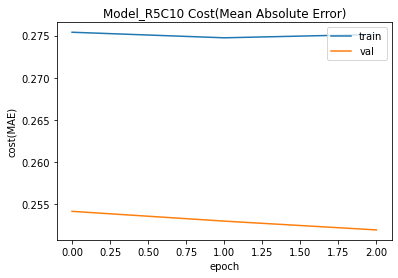

In [ ]:
plt.plot(train_costs_R5C10)
plt.plot(valid_costs_R5C10)
plt.title('Model_R5C10 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R5C20

In [ ]:
X_train_R5C20.shape

(8277, 80, 37)

In [ ]:
train_costs_R5C20 = []
valid_costs_R5C20 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R5C20, y_train_R5C20, RC='R5C20', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R5C20 += train_cost
valid_costs_R5C20 += valid_cost

'....> ....'....> ....'....> ....'....> 100th minibatch_cost 2.671626
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 2.426230
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.589775
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 2.933758
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 2.574138
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 3.880614
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'...After epoch 1 : Train Cost 0.236112 Valid Cost 0.231602
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> .

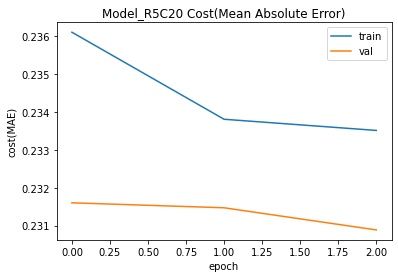

In [ ]:
plt.plot(train_costs_R5C20)
plt.plot(valid_costs_R5C20)
plt.title('Model_R5C20 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R5C50

In [ ]:
X_train_R5C50.shape

(8271, 80, 37)

In [ ]:
train_costs_R5C50 = []
valid_costs_R5C50 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R5C50, y_train_R5C50, RC='R5C50', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R5C50 += train_cost
valid_costs_R5C50 += valid_cost

....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 1.715192
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 2.822167
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.083598
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 3.305285
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 2.964030
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 1.826287
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'..After epoch 1 : Train Cost 0.220384 Valid Cost 0.217660
....'....> ....'....

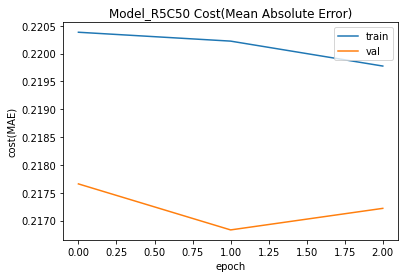

In [ ]:
plt.plot(train_costs_R5C50)
plt.plot(valid_costs_R5C50)
plt.title('Model_R5C50 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R20C10

In [ ]:
X_train_R20C10.shape

(8312, 80, 37)

In [ ]:
train_costs_R20C10 = []
valid_costs_R20C10 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R20C10, y_train_R20C10, RC='R20C10', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R20C10 += train_cost
valid_costs_R20C10 += valid_cost

....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 2.940550
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 3.273686
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.922838
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 2.326138
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 2.775700
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 2.393183
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> After epoch 1 : Train Cost 0.275388 Valid Cost 0.254158
....'....> ....'

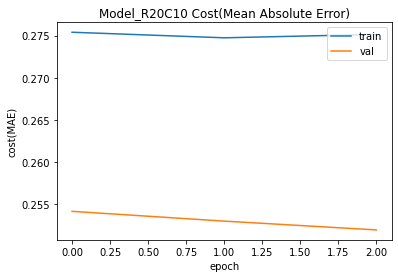

In [ ]:
plt.plot(train_costs_R20C10)
plt.plot(valid_costs_R20C10)
plt.title('Model_R20C10 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R20C20

In [ ]:
X_train_R20C20.shape

(6208, 80, 37)

In [ ]:
train_costs_R20C20 = []
valid_costs_R20C20 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R20C20, y_train_R20C20, RC='R20C20', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R20C20 += train_cost
valid_costs_R20C20 += valid_cost

..> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.341776
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 2.447051
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 2.462528
....'...After epoch 2 : Train Cost 0.254923 Valid Cost 0.260865
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 3.230413
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 2.820770
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.313389
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 2.447

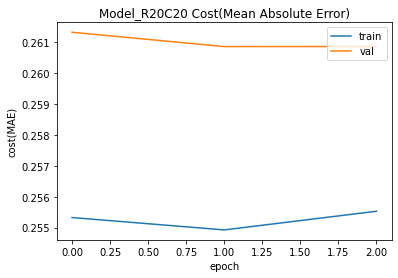

In [ ]:
plt.plot(train_costs_R20C20)
plt.plot(valid_costs_R20C20)
plt.title('Model_R20C20 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R20C50

In [ ]:
X_train_R20C50.shape

(8186, 80, 37)

In [ ]:
train_costs_R20C50 = []
valid_costs_R20C50 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R20C50, y_train_R20C50, RC='R20C50', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R20C50 += train_cost
valid_costs_R20C50 += valid_cost

..'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 3.785241
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 2.647578
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> After epoch 2 : Train Cost 0.237394 Valid Cost 0.233849
Down learning rate ( /=2 ) ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 2.898211
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 2.878079
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 3.078227
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 2.786911
..

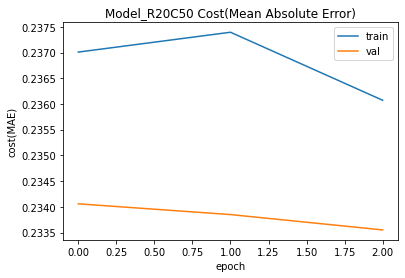

In [ ]:
plt.plot(train_costs_R20C50)
plt.plot(valid_costs_R20C50)
plt.title('Model_R20C50 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R50C10

In [ ]:
X_train_R50C10.shape

(13677, 80, 37)

In [ ]:
train_costs_R50C10 = []
valid_costs_R50C10 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R50C10, y_train_R50C10, RC='R50C10', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R50C10 += train_cost
valid_costs_R50C10 += valid_cost

....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 3.966027
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 2.567334
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 3.368215
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 3.301075
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 2.702393
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 3.250393
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 700th minibatch_cost 3.569784
....'....> ....'....

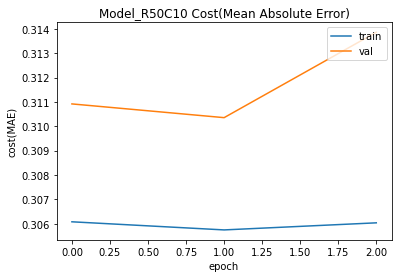

In [ ]:
plt.plot(train_costs_R50C10)
plt.plot(valid_costs_R50C10)
plt.title('Model_R50C10 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R50C20

In [ ]:
X_train_R50C20.shape

(8260, 80, 37)

In [ ]:
train_costs_R50C20 = []
valid_costs_R50C20 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R50C20, y_train_R50C20, RC='R50C20', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R50C20 += train_cost
valid_costs_R50C20 += valid_cost

....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 2.402799
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 2.696226
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.914913
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 4.262244
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 3.994512
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 3.497570
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'.After epoch 1 : Train Cost 0.310825 Valid Cost 0.314994
....'....> ....'....>

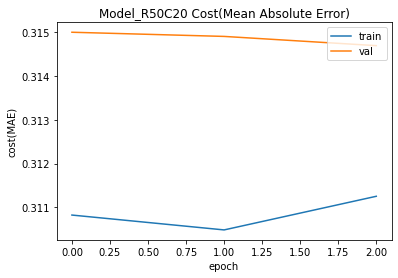

In [ ]:
plt.plot(train_costs_R50C20)
plt.plot(valid_costs_R50C20)
plt.title('Model_R50C20 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### R50C50

In [ ]:
X_train_R50C50.shape

(8189, 80, 37)

In [ ]:
train_costs_R50C50 = []
valid_costs_R50C50 = []

In [ ]:
train_cost, valid_cost = train_model(X_train_R50C50, y_train_R50C50, RC='R50C50', minibatch_size=minibatch_size, num_epochs=num_epochs)
train_costs_R50C50 += train_cost
valid_costs_R50C50 += valid_cost

....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 100th minibatch_cost 3.266113
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 200th minibatch_cost 3.205867
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 300th minibatch_cost 2.234822
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 400th minibatch_cost 2.179430
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 500th minibatch_cost 3.522162
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 600th minibatch_cost 2.842477
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> After epoch 1 : Train Cost 0.271827 Valid Cost 0.275838
....'....> ....'....> ....'

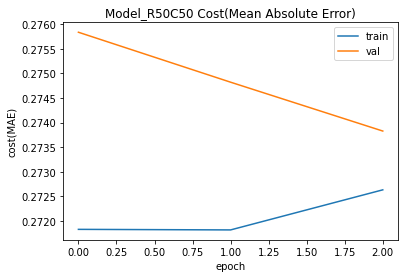

In [ ]:
plt.plot(train_costs_R50C50)
plt.plot(valid_costs_R50C50)
plt.title('Model_R50C50 Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Prediction

In [ ]:
# test_R5C10.shape (n, 80, 38)인데 38의 가장 앞은 id이므로 제외하고 생각하기
# 나머지도 마찬가지

In [ ]:
def predict(X_test, RC, minibatch_size):
    Model, _, _ = call_Model(RC, num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                                                l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate)
    
    input_pred = tf.data.Dataset.from_tensor_slices((X_test))
    pred_minibatches = input_pred.batch(minibatch_size).prefetch(8)

    prediction = np.zeros((1, 80))

    i = 0
    for minibatch_X in pred_minibatches:
        target_pred = np.zeros((minibatch_X.shape[0], 80, 1))
        #target_pred = np.ones((minibatch_X.shape[0], 80, 1))
        pred = Model(minibatch_X, target_pred, training=False)
        prediction = np.concatenate((prediction, pred))

        i += 1
        if i % 100 == 0:
            print('>', end=' ')
            if i % 1000 == 0:
              print(i, prediction.shape)
        elif i % 50 == 0:
            print('\'', end='')
        elif i % 10 == 0:
            print(".", end='')
        
        return prediction

In [ ]:
prediction_R5C10 = predict(X_test_R5C10, 'R5C10', minibatch_size)
prediction_R5C10 = np.ravel(prediction_R5C10[1:, :])
prediction_R5C20 = predict(X_test_R5C20, 'R5C20', minibatch_size)
prediction_R5C20 = np.ravel(prediction_R5C20[1:, :])
prediction_R5C50 = predict(X_test_R5C50, 'R5C50', minibatch_size)
prediction_R5C50 = np.ravel(prediction_R5C50[1:, :])

prediction_R20C10 = predict(X_test_R20C10, 'R20C10', minibatch_size)
prediction_R20C10 = np.ravel(prediction_R20C10[1:, :])
prediction_R20C20 = predict(X_test_R20C20, 'R20C20', minibatch_size)
prediction_R20C20 = np.ravel(prediction_R20C20[1:, :])
prediction_R20C50 = predict(X_test_R20C50, 'R20C50', minibatch_size)
prediction_R20C50 = np.ravel(prediction_R20C50[1:, :])

prediction_R50C10 = predict(X_test_R50C10, 'R50C10', minibatch_size)
prediction_R50C10 = np.ravel(prediction_R50C10[1:, :])
prediction_R50C20 = predict(X_test_R50C20, 'R50C20', minibatch_size)
prediction_R50C20 = np.ravel(prediction_R50C20[1:, :])
prediction_R50C50 = predict(X_test_R50C50, 'R50C50', minibatch_size)
prediction_R50C50 = np.ravel(prediction_R50C50[1:, :])

In [ ]:
for idx in idx_R5C10:
    submission[submission['id'] == idx]['pressure'] = prediction_R5C10[]
idx_R5C10
idx_R5C20
idx_R5C50

idx_R20C10
idx_R20C20
idx_R20C50

idx_R50C10
idx_R50C20
idx_R50C50

In [ ]:
X_test_R5C10.shape

(5437, 80, 37)

In [ ]:
idx_R5C10.shape

(5437, 80)

In [ ]:
np.ravel(idx_R5C10)

array([641., 642., 643., ...,   0.,   0.,   0.])

In [ ]:
idx_R5C10[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
submission[submission['id'] == idx_R5C10[0, 0]]['pressure']

640    0
Name: pressure, dtype: int64

In [ ]:
submission['pressure'] = prediction_flat
submission

In [ ]:
submission.to_csv('/content/drive/MyDrive/Ventilator_Pressure_Prediction/submission_ver4.csv', index=False)

In [ ]:
submission